# Pipeline Multivariate Descriptive
Análisis de 
- IGAE
- TC
- Tasa Int
- Otros

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pylab import rcParams
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf, pacf, adfuller, arma_order_select_ic
from sklearn.model_selection import ParameterGrid
import itertools
import warnings
import seaborn as sns



#Own packages
import download
import descriptive
import models_multivariate

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

# Importamos datos

In [6]:
# Importamos csv con ingresos brutos
ingresos_totales = download.load_ingresos_fiscales('../inputs/ingresos_tributarios_desglosados_updated.xlsx')

# Pib real
pib_r_df = download.load_pib_r()
pib_r_df_sa = download.load_pib_r(sa=True)
# Igaes
igae = download.load_inegi_indic('igae')
igae_prim = download.load_inegi_indic('igae_prim')
igae_secun = download.load_inegi_indic('igae_secun')
igae_terc = download.load_inegi_indic('igae_terc')

# Imai
imai = download.load_inegi_indic('imai')
imai_mineria = download.load_inegi_indic('imai_mineria')
imai_egergia_gas_agua_gas = download.load_inegi_indic('imai_egergia_gas_agua_gas')
imai_construccion = download.load_inegi_indic('imai_construccion')
imai_manufacturas = download.load_inegi_indic('imai_manufacturas')

# Otros indicadores de INEGI
confianza_consumidor = download.load_inegi_indic('confianza_consumidor')
indic_mens_consumo = download.load_inegi_indic('indic_mens_consumo')
indic_adelant = download.load_inegi_indic('indic_adelant')

# Ocupación
pea = download.load_inegi_indic('pea')
pobl_ocupada = download.load_inegi_indic('pobl_ocupada')
asegurados_imss = download.load_inegi_indic('asegurados_imss')

# Tipo de cambio
tc_mensual = download.load_banxico('tc_mensual')
tc_real = download.load_banxico('indice_tc_real')

# Tasas de interés
tasa_cetes_91_mensual = download.load_banxico('tasa_cetes_91_mensual')
tbill_3meses_mensual = download.load_fed('tbill_3meses_mensual')

# Precios
cons_price_index_us = download.load_fed('cons_price_index_us')
inpc = download.load_inpc()

# Indicadores US
ind_prod_ind_us = download.load_fed('ind_prod_ind_us')

#PIB real US
pib_r_us = download.load_fed('pibr_us_2012', monthly = True)

# Creamos DF conjunto

In [7]:
df_netos = pd.concat([ingresos_totales, igae, imai, pib_r_df, igae_prim, igae_secun, igae_terc,
                      confianza_consumidor, indic_mens_consumo, indic_adelant, pea, pobl_ocupada,
                      asegurados_imss, tc_mensual, tc_real, tasa_cetes_91_mensual,
                      tbill_3meses_mensual, cons_price_index_us, ind_prod_ind_us, pib_r_us, inpc], axis=1)

# Filtramos datos para solo tener después de 2005

In [8]:
dates_to_use = pd.date_range('2004-01-01', '2019-06-01', freq='MS')
df_netos = df_netos.loc[dates_to_use]

# Diccionario de columnas

In [9]:
df_netos.columns

Index(['ingresos_sector_publico_neto_(mdp)', 'ieps_neto_(mdp)',
       'ieps_sin_gas_neto_(mdp)', 'ing_gob_fed_neto_(mdp)',
       'ing_trib_neto_(mdp)', 'isr_neto_(mdp)', 'iva_neto_(mdp)',
       'importaciones_neto_(mdp)', 'ing_no_trib_neto_(mdp)',
       'ieps_hidrocarburos_neto_(mdp)',
       ...
       'pobl_ocupada', 'asegurados_imss', 'tc_mensual', 'indice_tc_real',
       'tasa_cetes_91_mensual', 'tbill_3meses_mensual', 'cons_price_index_us',
       'ind_prod_ind_us', 'pibr_us_2012', 'inpc'],
      dtype='object', length=142)

In [10]:
ingresos_tributarios_nominal = (['ingresos_sector_publico_neto_(mdp)', 'iva_neto_(mdp)', 'ieps_neto_(mdp)',
                                 'ieps_gasolina_neto_(mdp)', 'ing_no_trib_neto_(mdp)',
                                 'ing_gob_fed_neto_(mdp)', 'ing_trib_neto_(mdp)',
                                 'isr_neto_(mdp)', 'ing_trib_sin_gasol_neto_(mdp)',
                                 'ieps_sin_gas_neto_(mdp)'])
ingresos_tributarios_real = (['ingresos_sector_publico_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ieps_neto_(mdp)_r',
                              'ieps_gasolina_neto_(mdp)_r', 'ing_no_trib_neto_(mdp)_r',
                              'ing_gob_fed_neto_(mdp)_r', 'ing_trib_neto_(mdp)_r',
                              'isr_neto_(mdp)_r', 'ing_trib_sin_gasol_neto_(mdp)_r',
                              'ieps_sin_gas_neto_(mdp)_r'])
impuestos_netos = ['ing_trib_sin_gasol_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'isr_neto_(mdp)_r',\
                   'ieps_sin_gas_neto_(mdp)_r']

impuestos_brutos = ['ing_trib_bruto_(mdp)_r', 'iva_bruto_(mdp)_r', 'isr_bruto_(mdp)_r',\
                    'ieps_bruto_(mdp)_r']


igaes = ['igae', 'igae_prim', 'igae_secun', 'igae_terc']
imai = ['imai']
ocupacion = ['pea', 'pobl_ocupada']
asegurados = ['asegurados_imss']
indicadores_reales = ['confianza_consumidor', 'indic_mens_consumo', 'indic_adelant']
financieros = ['inpc', 'tc_mensual', 'indice_tc_real', 'cons_price_index_us', 'tasa_cetes_91_mensual',\
               'tbill_3meses_mensual']
pibs = ['pibr_2019', 'pibr_us_2012']
indice_produccion_us = ['ind_prod_ind_us']               

# Otros grupos no excluyentes, utiles
tasas_3_meses = ['tasa_cetes_91_mensual', 'tbill_3meses_mensual']
precios = ['inpc', 'cons_price_index_us']
indices_produccion = ['igae', 'ind_prod_ind_us']

# Columnas que se agregan usando promedio
agg_by_mean = igaes + ocupacion + indicadores_reales + financieros + pibs + indice_produccion_us + imai
# Columnas que se agregan con suma
agg_by_sum = ingresos_tributarios_nominal + ingresos_tributarios_real + impuestos_brutos
# Columnas que se agregan con el ultimo dato (Stock)
agg_by_last = asegurados

# Análisis variables
Vamos a analizar el comportamiento de las variables.

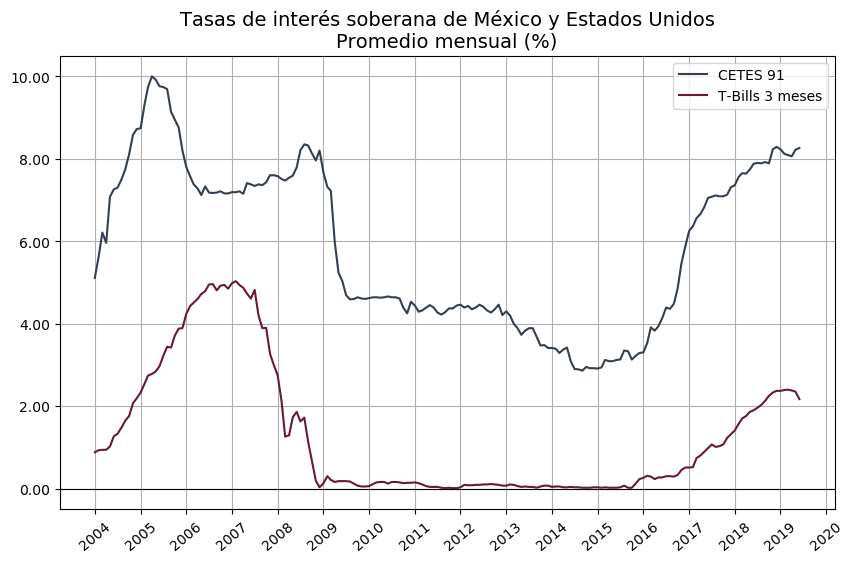

In [11]:
descriptive.plot_series(df = df_netos, 
                        cols = tasas_3_meses,
                        legend= ['CETES 91',
                                 'T-Bills 3 meses'],
                        title = 'Tasas de interés soberana de México y Estados Unidos',
                        subtitle = 'Promedio mensual (%)',
                        ticks='yearly', 
                        hline=0,
                        figsize = (10, 6),
                       dpi=100)

## Análisis anual

In [12]:
'inpc' in df_netos.columns

True

In [13]:
agg_by_mean_y = df_netos[agg_by_mean].resample('YS').mean()
agg_by_sum_y = df_netos[agg_by_sum].resample('YS').sum()
my_resample = lambda x: x.sort_index().tail(1)
agg_by_last_y = df_netos[agg_by_last].groupby(pd.TimeGrouper(freq='YS'), group_keys=False).apply(my_resample)
agg_by_last_y.index = pd.date_range('2004-01-01', '2019-01-01', freq='YS')

# Creamos base anual conjunta
yearly = pd.concat([agg_by_mean_y, agg_by_sum_y, agg_by_last_y], axis=1)

# Eliminamos ultimo año por recaudacion incompleta
yearly = yearly.iloc[:-1]

In [14]:
yearly.columns

Index(['igae', 'igae_prim', 'igae_secun', 'igae_terc', 'pea', 'pobl_ocupada',
       'confianza_consumidor', 'indic_mens_consumo', 'indic_adelant', 'inpc',
       'tc_mensual', 'indice_tc_real', 'cons_price_index_us',
       'tasa_cetes_91_mensual', 'tbill_3meses_mensual', 'pibr_2019',
       'pibr_us_2012', 'ind_prod_ind_us', 'imai',
       'ingresos_sector_publico_neto_(mdp)', 'iva_neto_(mdp)',
       'ieps_neto_(mdp)', 'ieps_gasolina_neto_(mdp)', 'ing_no_trib_neto_(mdp)',
       'ing_gob_fed_neto_(mdp)', 'ing_trib_neto_(mdp)', 'isr_neto_(mdp)',
       'ing_trib_sin_gasol_neto_(mdp)', 'ieps_sin_gas_neto_(mdp)',
       'ingresos_sector_publico_neto_(mdp)_r', 'iva_neto_(mdp)_r',
       'ieps_neto_(mdp)_r', 'ieps_gasolina_neto_(mdp)_r',
       'ing_no_trib_neto_(mdp)_r', 'ing_gob_fed_neto_(mdp)_r',
       'ing_trib_neto_(mdp)_r', 'isr_neto_(mdp)_r',
       'ing_trib_sin_gasol_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r',
       'ing_trib_bruto_(mdp)_r', 'iva_bruto_(mdp)_r', 'isr_bruto_(md

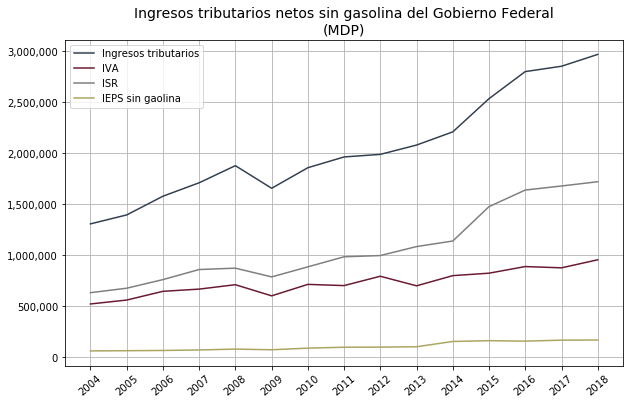

In [15]:
descriptive.plot_series(df = yearly, 
                        cols = impuestos_netos,
                        legend= ['Ingresos tributarios',
                                 'IVA',
                                 'ISR',
                                 'IEPS sin gaolina'],
                        title = 'Ingresos tributarios netos sin gasolina del Gobierno Federal',
                        subtitle = '(MDP)',
                        ticks='yearly', 
                        figsize = (10, 6))

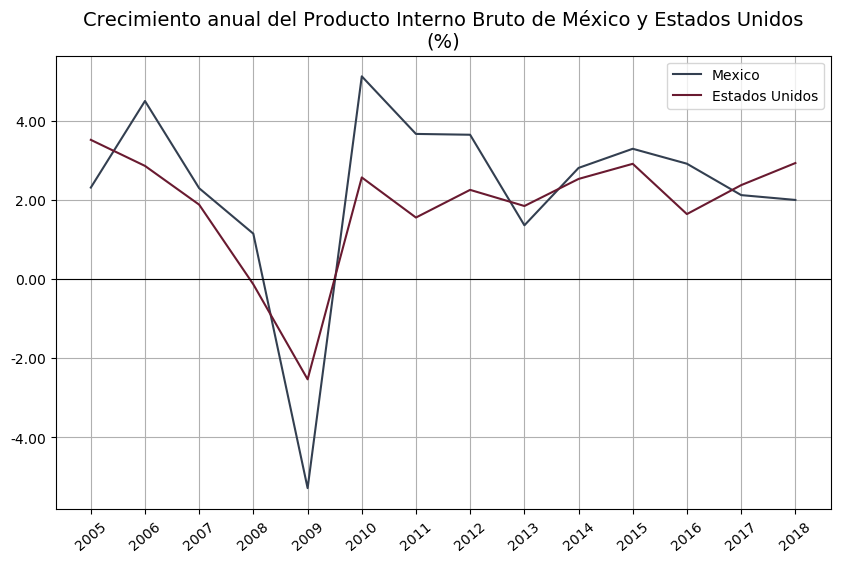

In [16]:
descriptive.plot_series(df = (yearly[pibs].pct_change()) * 100,
                        legend= ['Mexico',
                                 'Estados Unidos'],
                        title = 'Crecimiento anual del Producto Interno Bruto de México y Estados Unidos',
                        subtitle = '(%)',
                        ticks='yearly',
                        hline=0,
                        figsize = (10, 6),
                        dpi=100,
                        save_to='../figures/crecimiento_usa_mex.png')

### Indicador 2005 = 100

In [17]:
# Creamos indice base anual de indices
yearly_index = yearly.apply(lambda x: (x / x.iloc[0]) * 100)

In [21]:
yearly_index.columns

Index(['igae', 'igae_prim', 'igae_secun', 'igae_terc', 'pea', 'pobl_ocupada',
       'confianza_consumidor', 'indic_mens_consumo', 'indic_adelant', 'inpc',
       'tc_mensual', 'indice_tc_real', 'cons_price_index_us',
       'tasa_cetes_91_mensual', 'tbill_3meses_mensual', 'pibr_2019',
       'pibr_us_2012', 'ind_prod_ind_us', 'imai',
       'ingresos_sector_publico_neto_(mdp)', 'iva_neto_(mdp)',
       'ieps_neto_(mdp)', 'ieps_gasolina_neto_(mdp)', 'ing_no_trib_neto_(mdp)',
       'ing_gob_fed_neto_(mdp)', 'ing_trib_neto_(mdp)', 'isr_neto_(mdp)',
       'ing_trib_sin_gasol_neto_(mdp)', 'ieps_sin_gas_neto_(mdp)',
       'ingresos_sector_publico_neto_(mdp)_r', 'iva_neto_(mdp)_r',
       'ieps_neto_(mdp)_r', 'ieps_gasolina_neto_(mdp)_r',
       'ing_no_trib_neto_(mdp)_r', 'ing_gob_fed_neto_(mdp)_r',
       'ing_trib_neto_(mdp)_r', 'isr_neto_(mdp)_r',
       'ing_trib_sin_gasol_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r',
       'ing_trib_bruto_(mdp)_r', 'iva_bruto_(mdp)_r', 'isr_bruto_(md

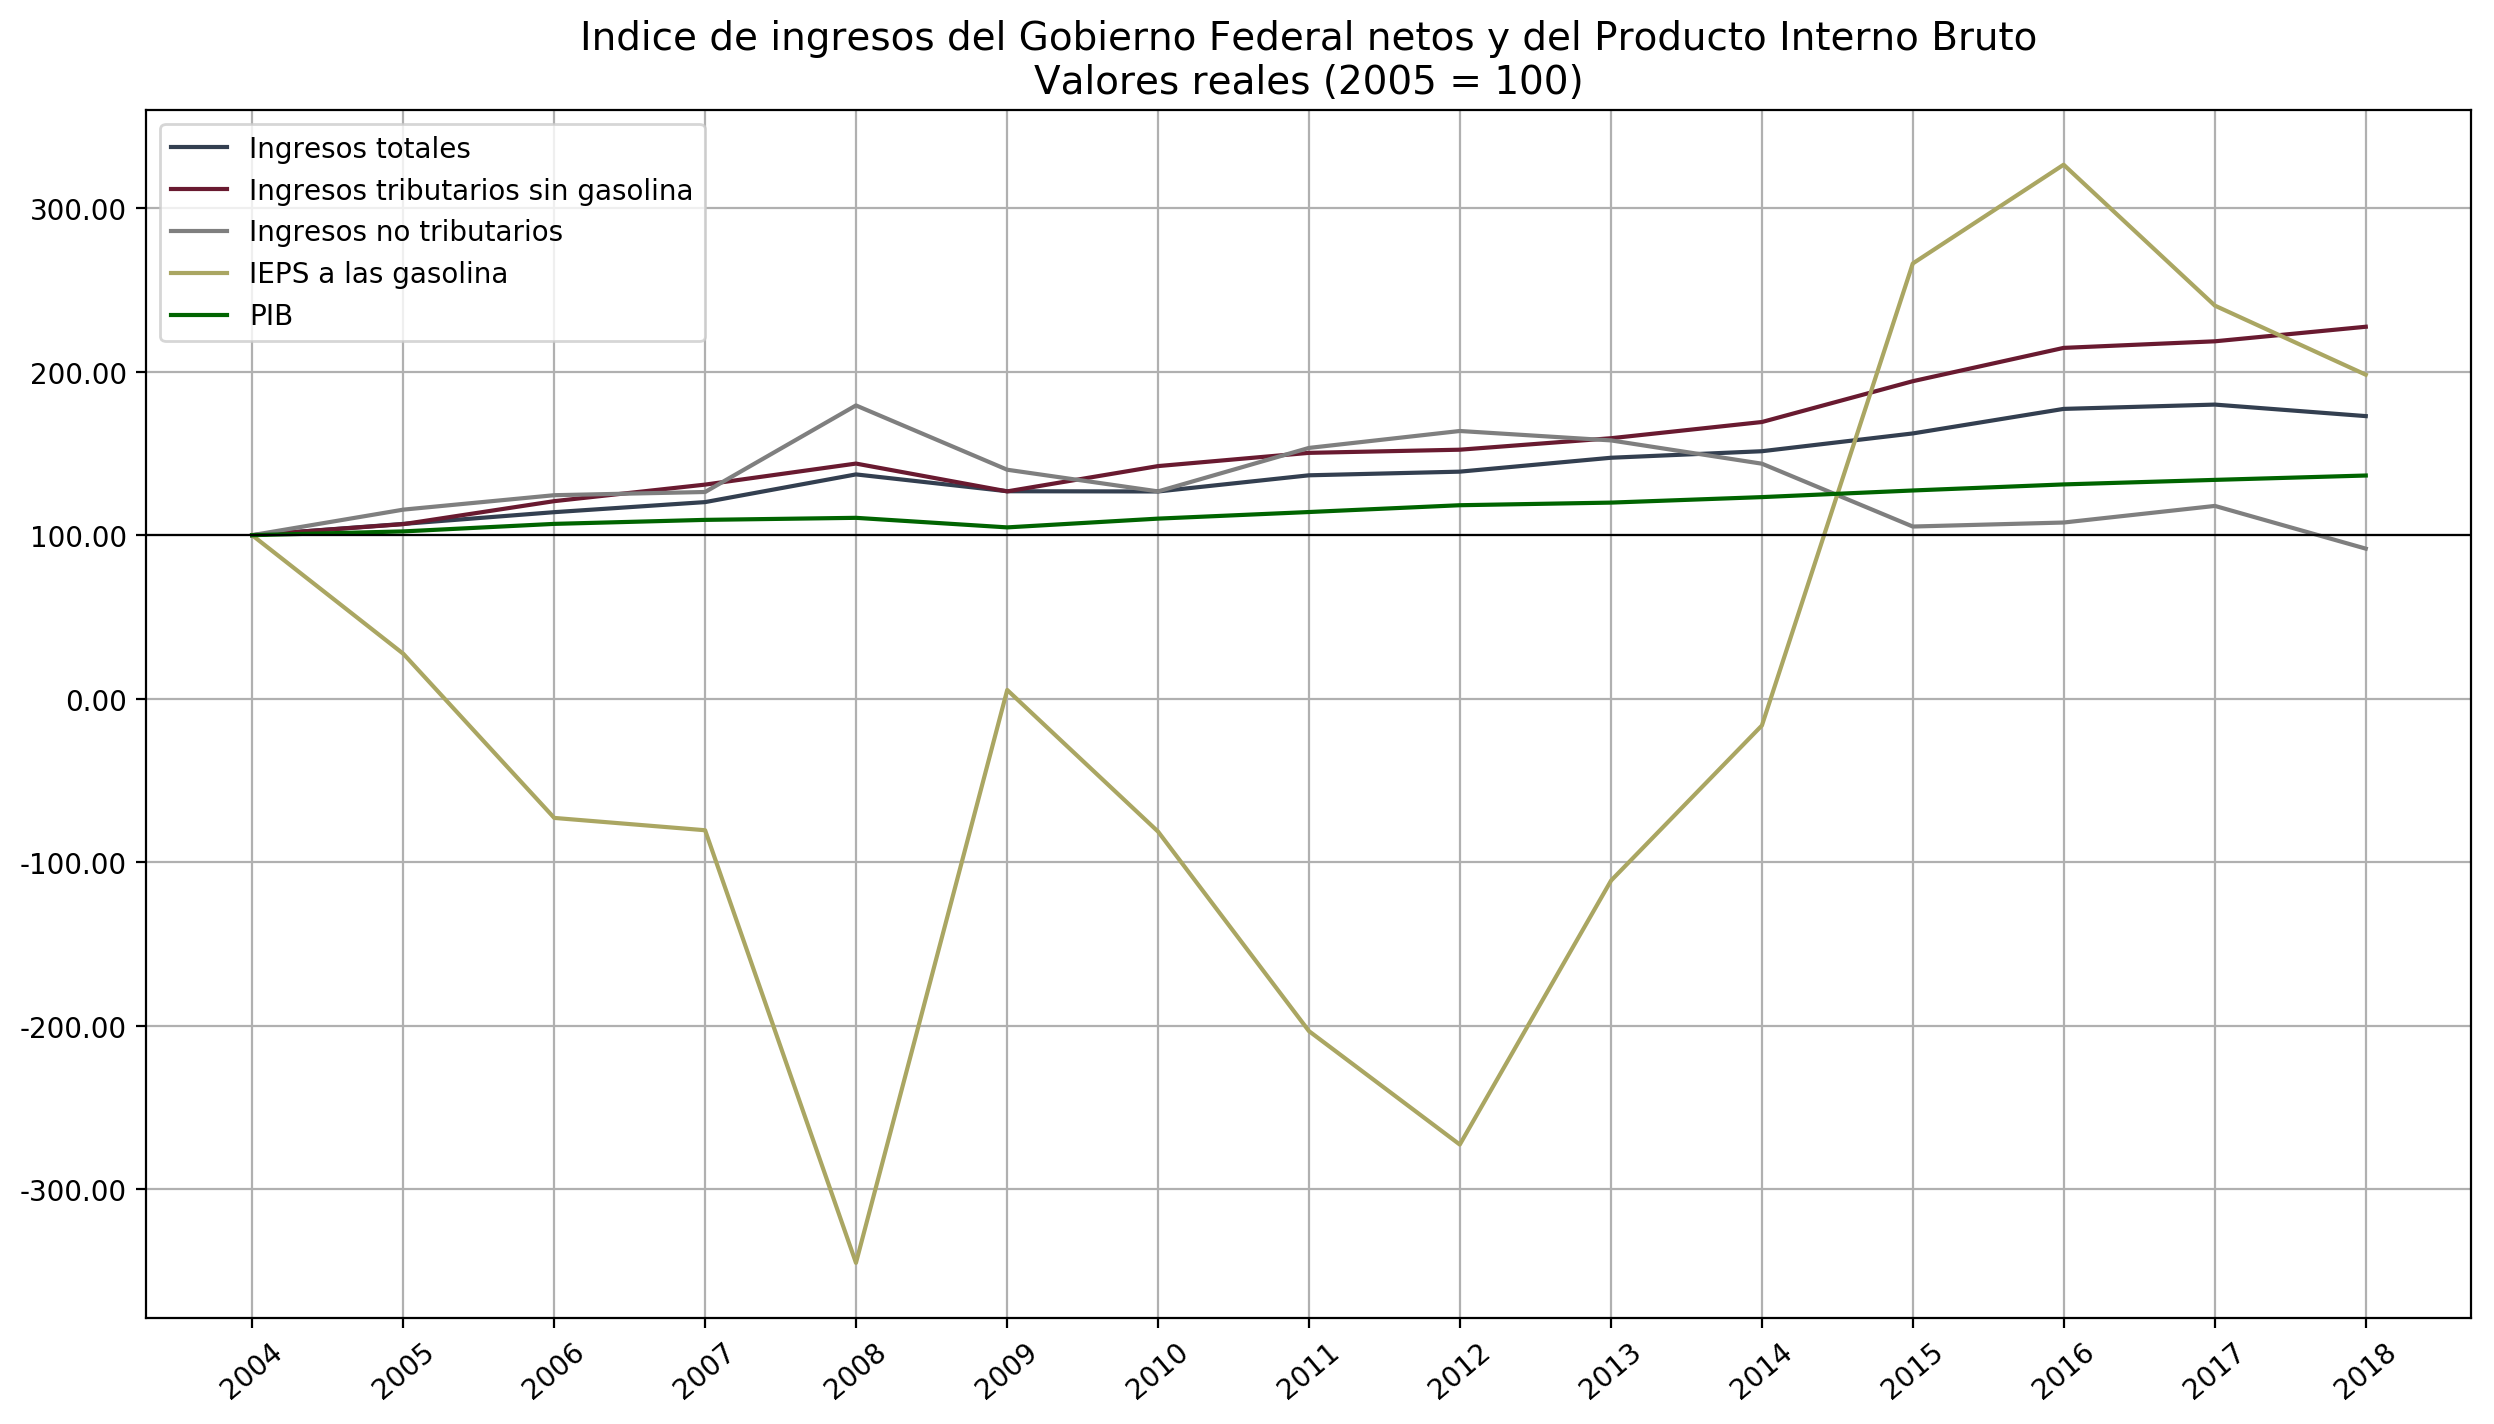

In [23]:
# Hacemos grafica de ingresos del gobierno federal, ingresos tributarios, no tributarios y pib
descriptive.plot_series(df = yearly_index, 
                        cols = ['ing_gob_fed_neto_(mdp)_r',
                                'ing_trib_sin_gasol_neto_(mdp)_r',
                                'ing_no_trib_neto_(mdp)_r',
                                'ieps_gasolina_neto_(mdp)_r',
                                'pibr_2019'],
                        legend= ['Ingresos totales',
                                 'Ingresos tributarios sin gasolina',
                                 'Ingresos no tributarios',
                                 'IEPS a las gasolina',
                                 'PIB'],
                        title = 'Indice de ingresos del Gobierno Federal netos y del Producto Interno Bruto',
                        subtitle = 'Valores reales (2005 = 100)',
                        ticks='yearly',
                        dpi=200,
                        hline=100,
                        save_to='../figures/indice_pib_ingresos_netos.png')

In [37]:
yearly_index.columns

Index(['igae', 'igae_prim', 'igae_secun', 'igae_terc', 'pea', 'pobl_ocupada',
       'confianza_consumidor', 'indic_mens_consumo', 'indic_adelant', 'inpc',
       'tc_mensual', 'indice_tc_real', 'cons_price_index_us',
       'tasa_cetes_91_mensual', 'tbill_3meses_mensual', 'pibr_2019',
       'pibr_us_2012', 'ind_prod_ind_us', 'imai',
       'ingresos_sector_publico_neto_(mdp)', 'iva_neto_(mdp)',
       'ieps_neto_(mdp)', 'ieps_gasolina_neto_(mdp)', 'ing_no_trib_neto_(mdp)',
       'ing_gob_fed_neto_(mdp)', 'ing_trib_neto_(mdp)', 'isr_neto_(mdp)',
       'ing_trib_sin_gasol_neto_(mdp)', 'ieps_sin_gas_neto_(mdp)',
       'ingresos_sector_publico_neto_(mdp)_r', 'iva_neto_(mdp)_r',
       'ieps_neto_(mdp)_r', 'ieps_gasolina_neto_(mdp)_r',
       'ing_no_trib_neto_(mdp)_r', 'ing_gob_fed_neto_(mdp)_r',
       'ing_trib_neto_(mdp)_r', 'isr_neto_(mdp)_r',
       'ing_trib_sin_gasol_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r',
       'ing_trib_bruto_(mdp)_r', 'iva_bruto_(mdp)_r', 'isr_bruto_(md

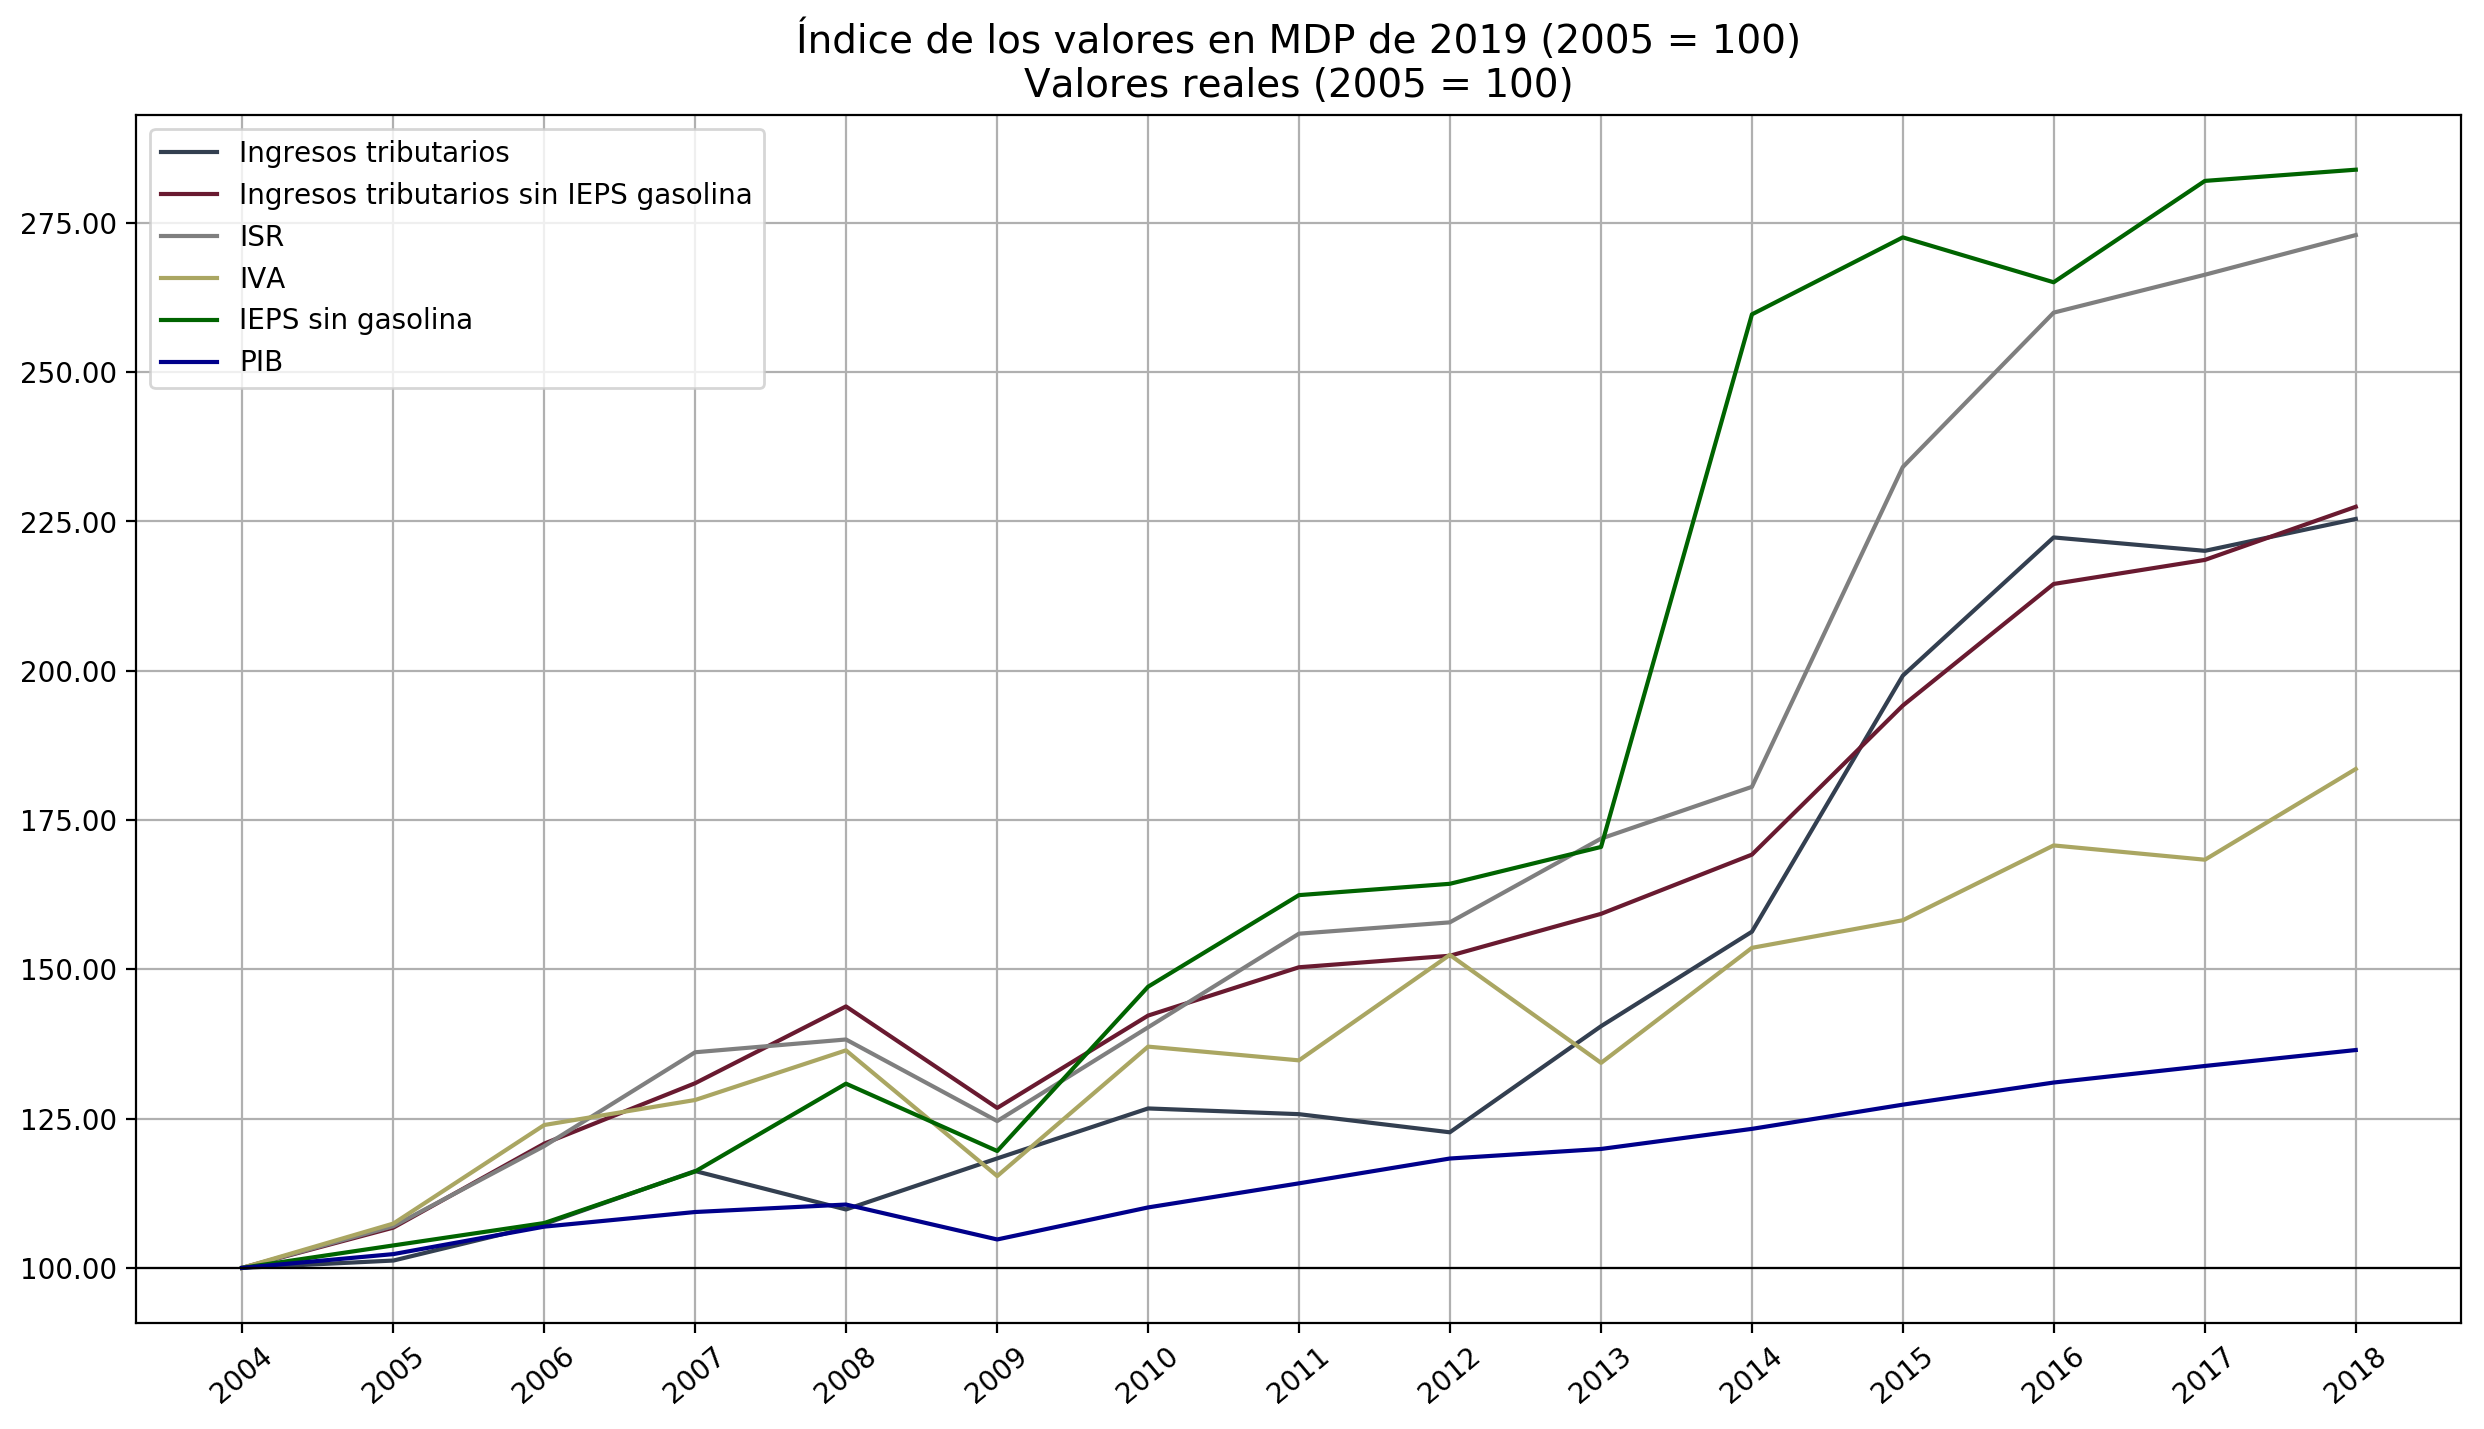

In [39]:
descriptive.plot_series(df = yearly_index, 
                        cols = ['ing_trib_neto_(mdp)_r',
                                'ing_trib_sin_gasol_neto_(mdp)_r',
                                'isr_neto_(mdp)_r',
                                'iva_neto_(mdp)_r',
                                'ieps_sin_gas_neto_(mdp)_r',
                                'pibr_2019'],
                        title = 'Índice de los valores en MDP de 2019 (2005 = 100)',
                        legend=['Ingresos tributarios',
                                'Ingresos tributarios sin IEPS gasolina',
                                'ISR',
                                'IVA',
                                'IEPS sin gasolina',
                                'PIB'],
                        subtitle = 'Valores reales (2005 = 100)',
                        ticks='yearly',
                        dpi = 200,
                        hline=100,
                        save_to='../reporte/figures/indice_pib_impuestos_netos.png')

In [47]:
cols_ing_trib = ['ing_trib_neto_(mdp)_r',
                 'ing_trib_sin_gasol_neto_(mdp)_r',
                 'isr_neto_(mdp)_r',
                 'iva_neto_(mdp)_r',
                 'ieps_sin_gas_neto_(mdp)_r',
                 'ieps_gasolina_neto_(mdp)_r',
                 'pibr_2019']

In [53]:
yearly_index[cols_ing_trib].pct_change().div(yearly_index['pibr_2019'].pct_change(), axis=0).loc['2016-01-01':].mean()

ing_trib_neto_(mdp)_r              1.577797
ing_trib_sin_gasol_neto_(mdp)_r    2.177360
isr_neto_(mdp)_r                   2.066026
iva_neto_(mdp)_r                   2.194152
ieps_sin_gas_neto_(mdp)_r          0.803492
ieps_gasolina_neto_(mdp)_r        -4.491092
pibr_2019                          1.000000
dtype: float64

In [44]:
yearly_index.loc['2018-01-01', ['ing_trib_neto_(mdp)_r',
                                'ing_trib_sin_gasol_neto_(mdp)_r',
                                'isr_neto_(mdp)_r',
                                'iva_neto_(mdp)_r',
                                'ieps_sin_gas_neto_(mdp)_r',
                                'ieps_gasolina_neto_(mdp)_r',
                                'pibr_2019']]

ing_trib_neto_(mdp)_r              225.419032
ing_trib_sin_gasol_neto_(mdp)_r    227.459076
isr_neto_(mdp)_r                   272.957773
iva_neto_(mdp)_r                   183.546289
ieps_sin_gas_neto_(mdp)_r          283.906951
ieps_gasolina_neto_(mdp)_r         198.134095
pibr_2019                          136.482489
Name: 2018-01-01 00:00:00, dtype: float64

In [ ]:
descriptive.plot_series(df = yearly_index, 
                        cols = pibs,
                        title='Índice del Producto Interno Bruto de México y Estados Unidos',
                        legend=['México',
                                'Estados Unidos'],
                        subtitle='Valores reales (2005 = 100)',
                        ticks='yearly',
                        dpi=200,
                        hline=100,
                        save_to='../figures/indice_pib_usa_mex.png')

In [ ]:
descriptive.plot_series(df = yearly_index, 
                        cols = precios,
                        title='Índices de precios de México y Estados Unidos',
                        legend=['México', 'Estados Unidos'],
                        subtitle = '(2014 = 100)',
                        dpi=100,
                        ticks='yearly',
                        hline=100)

In [ ]:
descriptive.plot_series(df = yearly_index, 
                        cols = precios,
                        title='Índices de precios al consumidor de México y Estados Unidos',
                        legend=['México',
                                'Estados Unidos'],
                        ticks='yearly',
                        dpi=100,
                        save_to='../figures/precios_usa_mex.png')

In [ ]:
igaes + indice_produccion_us + imai

In [ ]:
descriptive.plot_series(df = yearly_index, 
                        cols = imai + igaes + indice_produccion_us ,
                        title= 'Indicadores de actividad económica de México y Estados Unidos',
                        legend=['IGAE',
                                'IGAE primario',
                                'IGAE secundario',
                                'IGAE terciario',
                                'Índice Producción Industrial Estados Unidos',
                                'IMAI'],
                        subtitle='(2005 = 100)',
                        ticks='yearly')

In [ ]:
descriptive.plot_series(df = yearly_index, 
                        cols = indicadores_reales + indice_produccion_us,
                        title='Indicadores económicos de México y Estados Unidos',
                        legend=['Índice de Confianza a Consumidor en México', 
                                'Indicador mensual de consumo en México', 
                                'Indicador adelantado en México',
                                'Índice Producción Industrial Estados Unidos'],
                        subtitle='(2005 = 100)',
                        ticks='yearly')

### Ingresos tributarios como % del PIB

In [ ]:
fiscal_yearly_perc_pib = yearly[ingresos_tributarios_real].apply(lambda x: (x / yearly['pibr_2019']) * 100)

In [ ]:
descriptive.plot_series(df = fiscal_yearly_perc_pib, 
                        cols = ['ing_trib_sin_gasol_neto_(mdp)_r',
                                'isr_neto_(mdp)_r',
                                'iva_neto_(mdp)_r',
                                'ieps_sin_gas_neto_(mdp)_r'],
                        title = 'Ingresos tributarios netos sin IEPS gasolina',
                        subtitle = '(% del PIB)',
                        legend= ['Ingresos tributarios sin IEPS gasolina',
                                'ISR',
                                'IVA',
                                'IEPS sin gasolina'],
                        ticks='yearly',
                        dpi=200,
                        save_to='../figures/impuestos_netos_perc_pib.png')

Elasticidad anual de Ingresos Tributarios a PIB

In [ ]:
incremento_anual_tx = yearly[impuestos_netos].pct_change()
incremento_anual_pib = yearly['pibr_2019'].pct_change()
elasticidad_ingresos = incremento_anual_tx.div(incremento_anual_pib, axis=0)

In [ ]:
yearly

In [ ]:
elasticidad_ingresos

# Calculamos elasticidad de Largo Plazo

In [ ]:
colnames = df_netos.columns
new_colnames = [col.replace('(', '').replace(')', '') for col in colnames]
df_netos.columns = new_colnames

In [ ]:
elasticities = []

In [ ]:
for col in ['ingresos_gobierno_federal_neto_mdp_r',\
            'ingresos_tributarios_neto_sin_gasol_mdp_r',\
            'isr_neto_mdp_r',\
            'iva_neto_mdp_r',\
            'ieps_neto_sin_gasol_mdp_r']:
    for covars in ['', '+ np.log(tc_mensual)', '+ np.log(tc_mensual) + np.log(inpc)']:
        reg = smf.ols(formula='np.log({}) ~ np.log(igae) {}'.format(col, covars), data=df_netos).fit()
        print(reg.summary())
        print(reg.pvalues['np.log(igae)'])
        elasticities.append({'ingresos': col, 
                             'covars': covars,
                             'coef': round(reg.params['np.log(igae)'], 3),
                             'std_err': round(reg.bse['np.log(igae)'], 3),
                             'pval': round(reg.pvalues['np.log(igae)'], 3)})

In [ ]:
elasticities_df = pd.DataFrame(elasticities)

In [ ]:
elasticities_df = elasticities_df[['ingresos', 'covars', 'coef', 'std_err', 'pval']]
elasticities_df

# Crear mas variables

In [ ]:
# Creamos dummies mensuales
df_netos['month'] = df_netos.index.map(lambda x: x.month)
inicios_sexenios = [2007, 2013, 2019]
df_netos['inicio_sexenio'] = np.where(df_netos.index.year.isin(inicios_sexenios), 1, 0)
fin_sexenios = [2006, 2018]
df_netos['fin_sexenio'] = np.where(df_netos.index.year.isin(fin_sexenios), 1, 0)

# Graficando indice de ingresos brutos

In [ ]:
ingresos_sat = download.load_ingresos_fiscales_sat()
ingresos_sat_yearly = ingresos_sat.resample('YS').sum()

In [ ]:
ingresos_sat_yearly = ingresos_sat_yearly.merge(pib_yearly, left_index=True, right_index=True)
ingresos_sat_yearly_index = ingresos_sat_yearly.apply(lambda x: (x / x.iloc[0]) * 100 )

In [ ]:
ingresos_sat_yearly_index = ingresos_sat_yearly_index.loc[ingresos_sat_yearly_index.index < '2019-01-01']

In [ ]:
ingresos_sat_yearly_index.columns

In [ ]:
# Hacemos grafica de ingresos del gobierno federal, ingresos tributarios, no tributarios y pib
descriptive.plot_series(df = ingresos_sat_yearly_index, 
                        cols = ['ing_tot_brut_(mdp)_r',
                                'ing_trib_brut_(mdp)_r',
                                'ing_no_trib_bruto_(mdp)_r',
                                'pibr_2019'],
                        legend= ['Ingresos totales',
                                 'Ingresos tributarios',
                                 'Ingresos no tributarios',
                                 'PIB'],
                        title = 'Indice de ingresos del Gobierno Federal brutos y del Producto Interno Bruto',
                        subtitle = 'Valores reales (2014 = 100)',
                        ticks='yearly',
                        save_to='../figures/indice_pib_ingresos_brutos.png')

In [ ]:
# Hacemos grafica de ingresos del gobierno federal, ingresos tributarios, no tributarios y pib
descriptive.plot_series(df = ingresos_sat_yearly_index, 
                        cols = ['ing_trib_brut_(mdp)_r',
                                'iva_bruto_(mdp)_r',
                                'isr_bruto_(mdp)_r',
                                'ieps_bruto_(mdp)_r',
                                'iva_neto_(mdp)_r',
                                'pibr_2019'],
                        legend= ['Ingresos totales',
                                 'IVA',
                                 'ISR',
                                 'IEPS',
                                 'IVA neto',
                                 'PIB'],
                        title = 'Indice de ingresos del Gobierno Federal brutos y del Producto Interno Bruto',
                        subtitle = 'Valores reales (2014 = 100)',
                        ticks='yearly',
                        save_to='../figures/indice_pib_impuestos_brutos.png')

# Calculando elasticidades

In [ ]:
df_brutos = pd.merge(ingresos_sat, igae, left_index=True, right_index=True)
df_brutos = pd.merge(df_brutos, pib_r_df, left_index=True, right_index=True)
df_brutos = pd.merge(df_brutos, tc, left_index=True, right_index=True)

In [ ]:
df_brutos_log = df_brutos.apply(np.log)
df_brutos_log = df_brutos_log.add_prefix('ln_')
columns = df_brutos_log.columns
newcolumns = [col.replace('(', '').replace(')', '') for col in  columns]
df_brutos_log.columns = newcolumns

In [ ]:
df_brutos_log.columns

In [ ]:
for col in ['ln_ing_trib_brut_mdp_r',\
            'ln_iva_bruto_mdp_r',\
            'ln_isr_bruto_mdp_r',\
            'ln_ieps_bruto_mdp_r',\
            'ln_ing_trib_neto_mdp_r',\
            'ln_iva_neto_mdp_r',\
            'ln_isr_neto_mdp_r',\
            'ln_ieps_neto_mdp_r']:
    reg = smf.ols(formula='{} ~ ln_igae'.format(col), data=df_brutos_log).fit()
    print(reg.summary())
    elasticities['2014-2018'].append({col: {'coef': reg.params['ln_igae'], 'std_err': reg.bse['ln_igae']}})